In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

In [2]:
az.style.use("arviz-white")

# Logistic regression for NBA clutch free throws

### Chapter 4.3.3: Generalized linear models

The NBA clutch free throws data set has three variables for player $i=1,...,10$:

1.  $Y_i$ is the number clutch free throws made
2.  $N_i$ is the number clutch free throws attempted
3.  $q_i$ is the proportion of the non-clutch free throws made

We model these data as
$$Y_i\sim\mbox{Binomial}(N_i,p_i),$$
where $p_i$ is the true probability of making a clutch shot.  The objective is to explore the relationship between clutch and overall percentages, $p_i$ and $q_i$.  We do this using two logistic regression models:

1.  $\mbox{logit}(p_i) = \beta_1 + \beta_2\mbox{logit}(q_i)$
2.  $\mbox{logit}(p_i) = \beta_1 + \mbox{logit}(q_i)$

In both models we select uninformative priors $\beta_j\sim\mbox{Normal}(0,10^2)$.

In the first model, $p_i=q_i$ if $\beta_1=0$ and $\beta_2=1$; in the second model $p_i=q_i$ if $\beta_1=0$. Therefore, we compare the posteriors of the $\beta_j$ to these values to analyze the relationship between $p_i$ and $q_i$.

In [3]:
## Load the data
np.random.seed(820)

Y = np.array([64, 72, 55, 27, 75, 24, 28, 66, 40, 13])
N = np.array([75, 95, 63, 39, 83, 26, 41, 82, 54, 16])
q = np.array([0.845, 0.847, 0.880, 0.674, 0.909, 0.899, 0.770, 0.801, 0.802, 0.875])

X = np.log(q) - np.log(1 - q)  # X = logit(q)

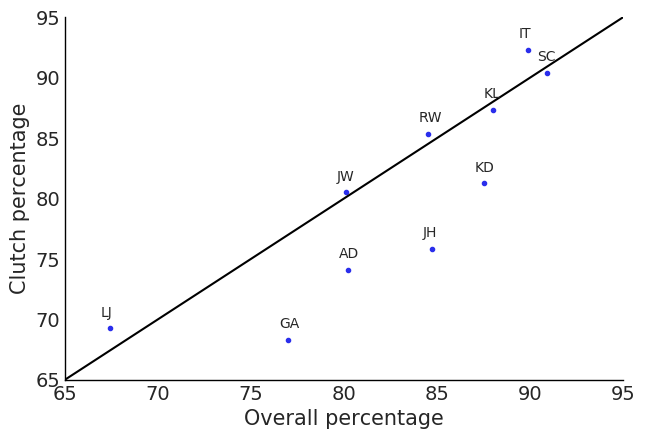

In [4]:
## Plot the data
inits = ("RW", "JH", "KL", "LJ", "SC", "IT", "GA", "JW", "AD", "KD")
plt.plot(100 * q, 100 * Y / N, ".")
plt.xlim(65, 95)
plt.ylim(65, 95)
plt.xlabel("Overall percentage")
plt.ylabel("Clutch percentage")
for i, txt in enumerate(inits):
    plt.annotate(txt, (100 * q[i] - 0.5, 100 * Y[i] / N[i] + 1))
plt.plot(plt.xlim(), plt.ylim(), "k");

In [5]:
with pm.Model() as model_1:
    # Priors
    β = pm.Normal("β", 0, 100, shape=2)
    p = pm.math.sigmoid(β[0] + β[1] * X)
    # likelihood
    y = pm.Binomial("y", n=N, p=p, observed=Y)
    samples_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1355.78draws/s]
The number of effective samples is smaller than 25% for some parameters.


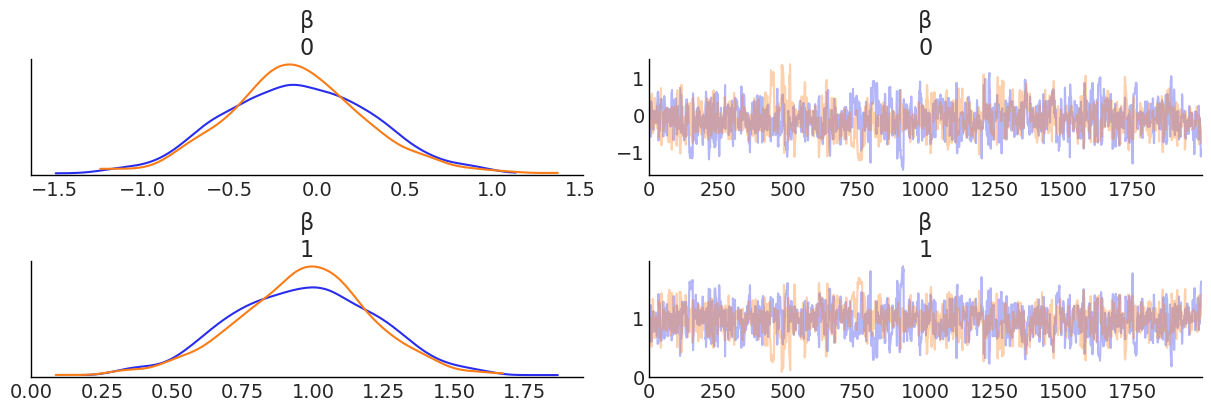

In [6]:
az.plot_trace(samples_1);

In [7]:
az.summary(samples_1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β[0],-0.119,0.421,-0.867,0.714,0.019,0.014,488.0,440.0,499.0,480.0,1.0
β[1],0.963,0.257,0.471,1.435,0.012,0.008,492.0,492.0,499.0,613.0,1.0


In [8]:
with pm.Model() as model_2:
    # Priors
    β = pm.Normal("β", 0, 100)
    p = pm.math.sigmoid(β + X)
    # likelihood
    y = pm.Binomial("y", n=N, p=p, observed=Y)
    samples_2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:01<00:00, 3423.53draws/s]
The acceptance probability does not match the target. It is 0.8933537032412815, but should be close to 0.8. Try to increase the number of tuning steps.


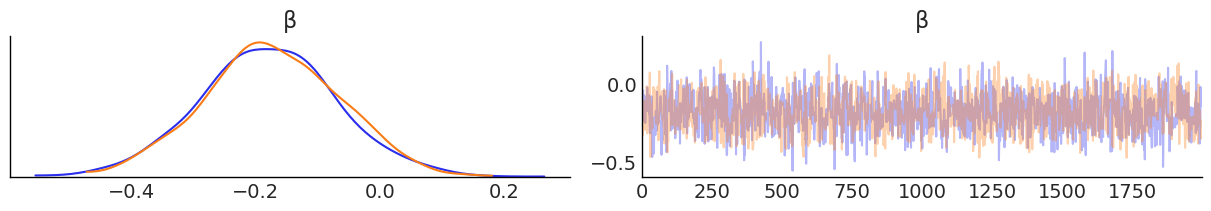

In [9]:
az.plot_trace(samples_2);

In [10]:
az.summary(samples_2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β,-0.179,0.11,-0.39,0.02,0.003,0.002,1518.0,1518.0,1514.0,2528.0,1.0


In [11]:
np.mean(samples_2["β"] < 0)

0.946

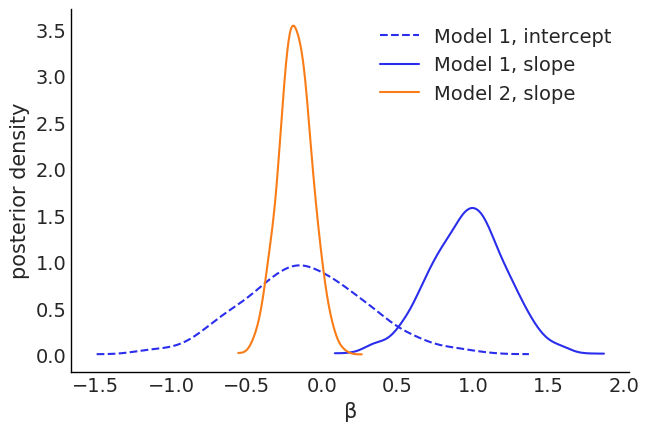

In [12]:
az.plot_kde(
    samples_1["β"][:, 0], label="Model 1, intercept", plot_kwargs={"color": "C0", "ls": "--"}
)
az.plot_kde(samples_1["β"][:, 1], label="Model 1, slope", plot_kwargs={"color": "C0"})
az.plot_kde(samples_2["β"], label="Model 2, slope", plot_kwargs={"color": "C1"})

plt.ylabel("posterior density")
plt.xlabel("β");